In [1]:
# Python Project Template

### 1. Prepare Problem
#### a) Load libraries
#### b) Load dataset

### 2. Summarize Data
#### a) Descriptive statistics
#### b) Data visualizations

### 3. Prepare Data
#### a) Data Cleaning
#### b) Feature Selection
#### c) Data Transform

### 4. Evaluate Algorithms
#### a) Split-out validation dataset
#### b) Test options and evaluation metric
#### c) Spot check Algorithms

### 5. Improve Accuracy
#### a) Algorithm Tuning
#### b) Ensembles

### 6. Finalize Model 
#### a) Predictions on validation dataset
#### b) Create standalone model on entire training dataset
#### c) Save model for later use

This is the data set used by Gorman and Sejnowski in their study of the classification of sonar signals. The task is to train a network to discriminate between sonar signals bounced off a metal cylinder and those bounced off a roughly cylindrical rock

The data set contains the response metrics for 60 separate sonar frequency bins sent out against a known mine field (and known rocks). These frequencies are then labeled with the known object they were beaming the sound at.

### 1. Prepare Problem

#### a) Load libraries

In [3]:
import numpy as np
import pandas as pd
#from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns

#from pickle import dump
#from pickle import load

from sklearn.decomposition import PCA
#from sklearn.feature_selection import SelectKBest

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

#### b) Load dataset

In [4]:
# Load dataset
filename = 'sonar-data.csv'
df = pd.read_csv(filename, header=None)
df.rename(columns=lambda x: f'freqbin_{x + 1:02d}' if isinstance(x, int) else x, inplace=True) # Rename columns by adding "freqbin_" before the numbers
df.rename(columns={'freqbin_61': 'target'}, inplace=True) # Rename the last column by adding "freqbin_" before the column name

In [30]:
df.tail()

,freqbin_01,freqbin_02,freqbin_03,freqbin_04,freqbin_05,freqbin_06,freqbin_07,freqbin_08,freqbin_09,freqbin_10,...,freqbin_52,freqbin_53,freqbin_54,freqbin_55,freqbin_56,freqbin_57,freqbin_58,freqbin_59,freqbin_60,target
203,0.0187,0.0346,0.0168,0.0177,0.0393,0.1630,0.2028,0.1694,0.2328,0.2684,...,0.0116,0.0098,0.0199,0.0033,0.0101,0.0065,0.0115,0.0193,0.0157,M
204,0.0323,0.0101,0.0298,0.0564,0.0760,0.0958,0.0990,0.1018,0.1030,0.2154,...,0.0061,0.0093,0.0135,0.0063,0.0063,0.0034,0.0032,0.0062,0.0067,M
205,0.0522,0.0437,0.0180,0.0292,0.0351,0.1171,0.1257,0.1178,0.1258,0.2529,...,0.0160,0.0029,0.0051,0.0062,0.0089,0.0140,0.0138,0.0077,0.0031,M
206,0.0303,0.0353,0.0490,0.0608,0.0167,0.1354,0.1465,0.1123,0.1945,0.2354,...,0.0086,0.0046,0.0126,0.0036,0.0035,0.0034,0.0079,0.0036,0.0048,M
207,0.0260,0.0363,0.0136,0.0272,0.0214,0.0338,0.0655,0.1400,0.1843,0.2354,...,0.0146,0.0129,0.0047,0.0039,0.0061,0.0040,0.0036,0.0061,0.0115,M


### 2. Summarize Data

#### a) Descriptive statistics

In [31]:
# dimensions
print(df.shape)

(208, 61)


In [7]:
# types
print(df.dtypes)

freqbin_01    float64
freqbin_02    float64
freqbin_03    float64
freqbin_04    float64
freqbin_05    float64
               ...   
freqbin_57    float64
freqbin_58    float64
freqbin_59    float64
freqbin_60    float64
target         object
Length: 61, dtype: object


In [8]:
# descriptions
df.describe().transpose().head()

,count,mean,std,min,25%,50%,75%,max
freqbin_01,208.0,0.029164,0.022991,0.0015,0.013350,0.02280,0.035550,0.1371
freqbin_02,208.0,0.038437,0.032960,0.0006,0.016450,0.03080,0.047950,0.2339
freqbin_03,208.0,0.043832,0.038428,0.0015,0.018950,0.03430,0.057950,0.3059
freqbin_04,208.0,0.053892,0.046528,0.0058,0.024375,0.04405,0.064500,0.4264
freqbin_05,208.0,0.075202,0.055552,0.0067,0.038050,0.06250,0.100275,0.4010


In [9]:
# class distribution
df.groupby('target').size()

target
M    111
R     97
dtype: int64

#### b) Data visualizations

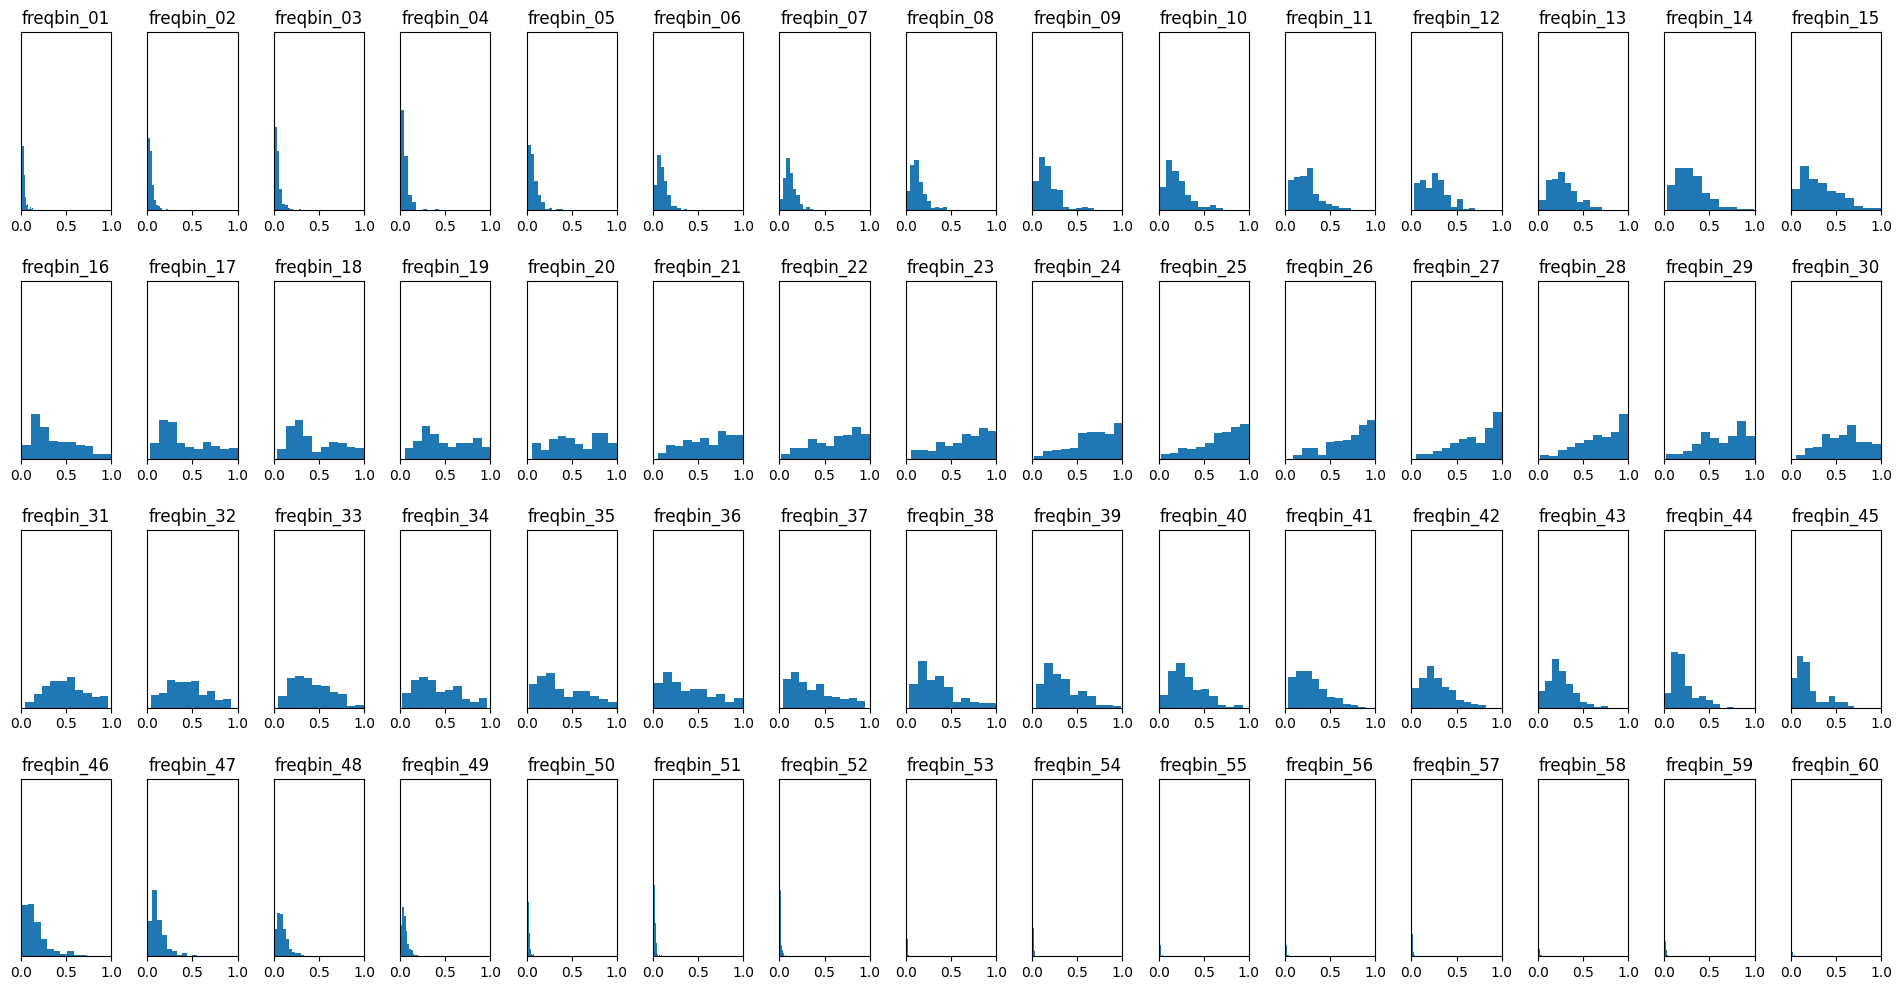

In [10]:
#plot histograms 

subplot_rows = 4
subplot_cols = 15

fig, axs = plt.subplots(subplot_rows, subplot_cols, figsize=(24, 12))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

# Iterate through the subplots and plot the histograms
for i in range(subplot_rows):
    for j in range(subplot_cols):
        column_index = (i * subplot_cols) + j
        axs[i, j].set_xlim(0, 1)
        axs[i, j].set_ylim(0, 1)
        weights = np.ones_like(df.iloc[:, column_index]) / len(df.iloc[:, column_index]) # calculatin weight because the parameter 'density=True' in plt.hist doesnt work properly
        axs[i, j].set_yticks([])
        axs[i, j].hist(df.iloc[:, column_index], bins=10, weights=weights) # the parameter 'density=True' doesnt work as we think
        axs[i, j].set_title(f'{df.columns[column_index]}')

plt.show()

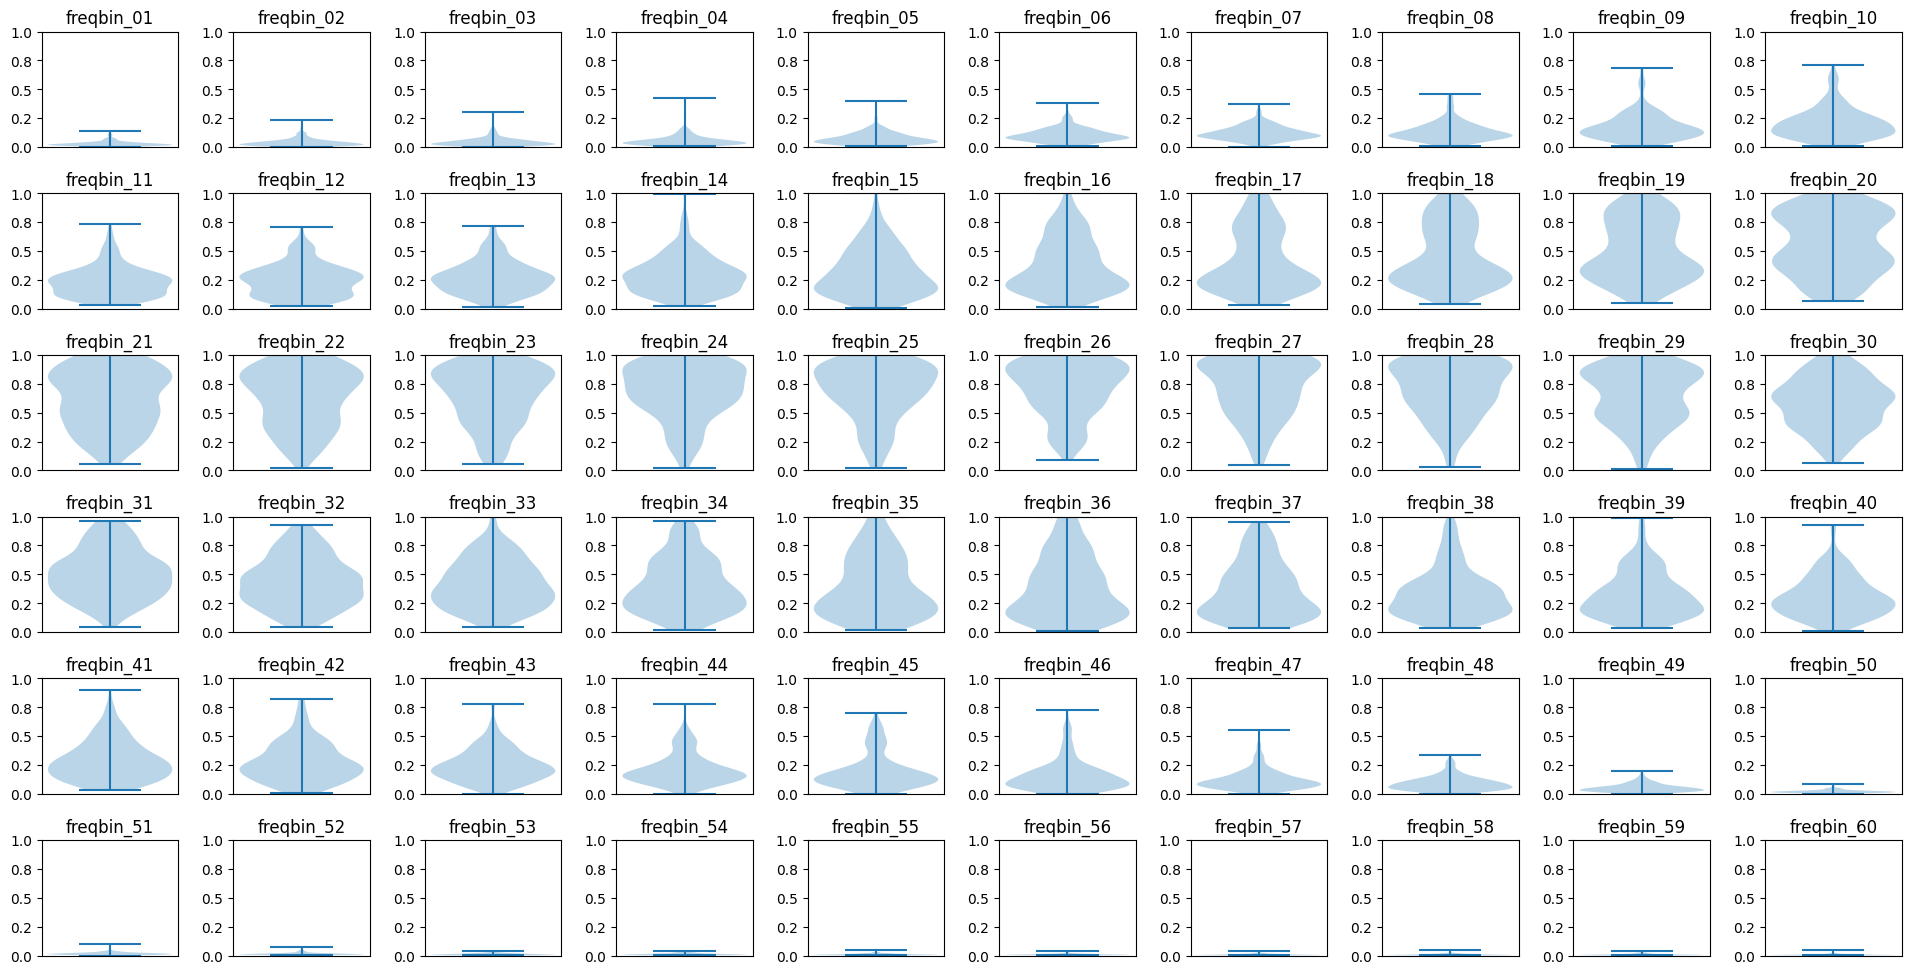

In [11]:
#plot boxplot 
fig, axs = plt.subplots(6, 10, figsize=(24, 12))
plt.subplots_adjust(wspace=0.4, hspace=0.4)


# Iterate through the subplots and plot the histograms
for i in range(6):
    for j in range(10):
        column_index = i * 10 + j
        axs[i, j].set_xticks([])
        axs[i, j].set_ylim(0, 1)
        axs[i, j].violinplot(df.iloc[:, column_index])
        axs[i, j].set_title(f'{df.columns[column_index]}')
        axs[i, j].yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))

plt.show()

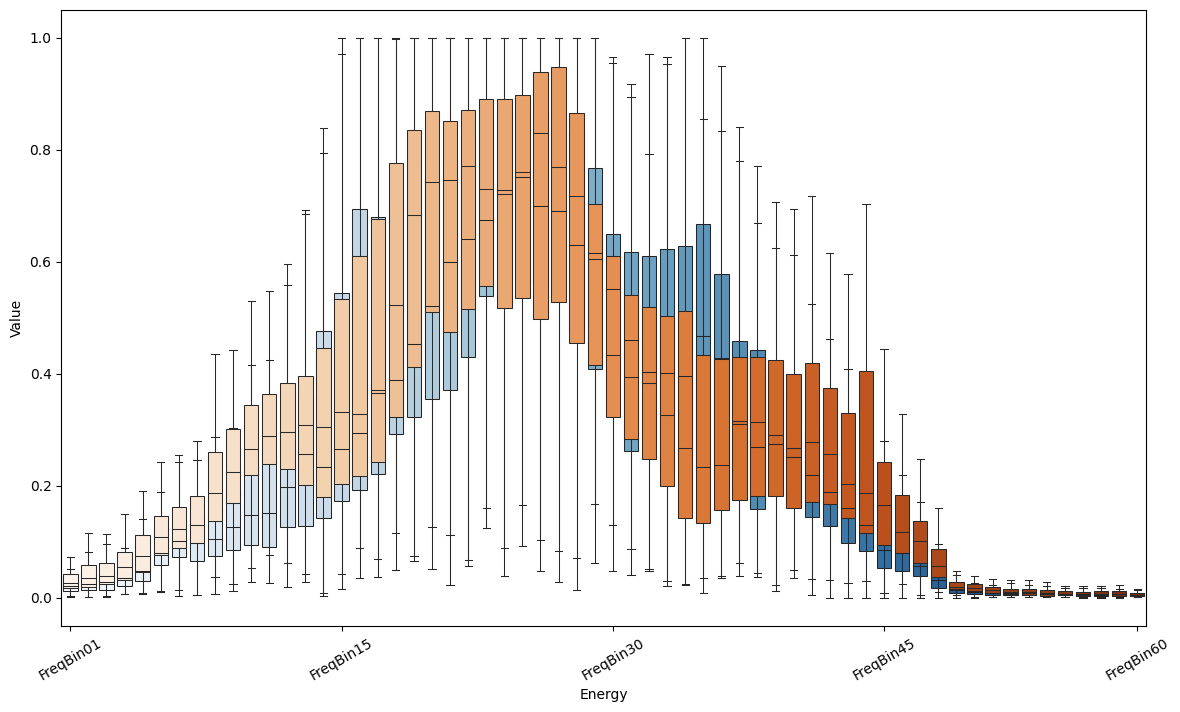

In [12]:
#
sonar_selected_r = df[df['target'] == 'R'].iloc[:, :-1]
sonar_selected_m = df[df['target'] == 'M'].iloc[:, :-1]

# Pivot the DataFrame
sonar_pivot_r = sonar_selected_r.melt(var_name='Energy', value_name='Value')
sonar_pivot_m = sonar_selected_m.melt(var_name='Energy', value_name='Value')

# Convert 'Energy' column to categorical
sonar_pivot_r['Energy'] = pd.Categorical(sonar_pivot_r['Energy'])
sonar_pivot_m['Energy'] = pd.Categorical(sonar_pivot_m['Energy'])

# Plot
plt.figure(figsize=(14, 8))
sns.boxplot(x='Energy', y='Value', hue='Energy', data=sonar_pivot_r, orient='v', palette='Blues', showfliers=False, linewidth=.75)
sns.boxplot(x='Energy', y='Value', hue='Energy', data=sonar_pivot_m, orient='v', palette='Oranges', showfliers=False, linewidth=.75)

plt.xticks([0, 15, 30, 45, 59], ['FreqBin01', 'FreqBin15', 'FreqBin30', 'FreqBin45', 'FreqBin60'], rotation=30)
plt.xlabel('Energy')
plt.ylabel('Value')
plt.show()

In [13]:
def corr_graph(df, txt):
    # plot correlation matrix
    correlations = df.corr()
    col_length = len(correlations.columns)

    # modifying it to only include values below the diagonal
    ones = np.ones(correlations.shape) # return a new array filled with ones of a given shape and type
    mask = np.tril(ones, k=-1).astype(np.bool) # lower triangle of an array + substitute 0 for False
    new_correlations = correlations.where(mask) # replace values where the condition is False

    # ploting
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    cax = ax.matshow(new_correlations, cmap='RdBu', vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0, col_length, 1)

    # Loop over data dimensions and create text annotations
    if txt == True:
        for i in range(col_length):
            for j in range(col_length):
                # Add text annotation only where mask is True (non-zero)
                if mask[i, j] == True:
                    text = ax.text(j, i, round(new_correlations.to_numpy()[i, j], 1),
                            ha="center", va="center", color="black", fontsize='small')
    plt.show()

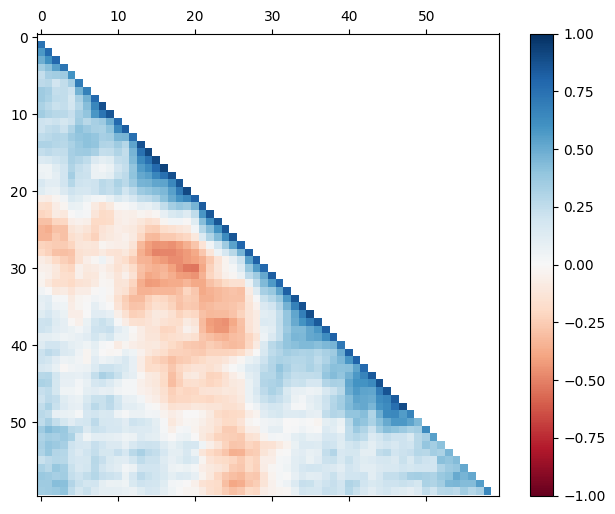

In [14]:
numeric_df = df.select_dtypes(include=['number'])
corr_graph(numeric_df, False)

### 3. Prepare Data

#### a) Data Cleaning

In [15]:
#All the values are numerical. Therefore, no cleaning is required!
# Check for NaN values
total_nan = df.isna().sum().sum()
print(f"Total NaN values in the dataset: {total_nan}")

Total NaN values in the dataset: 0


#### b) Feature Selection

In [32]:
# for this dataset, we don't need to do it

#### c) Data Transform

In [17]:
# for this dataset, we don't need to do it

### 4. Evaluate Algorithms

#### a) Split-out validation dataset

In [18]:
# Split-out validation dataset
array = df.values
X = array[:,0:-1].astype(float)
Y = array[:,-1]
validation_size = 0.2
seed = 7
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=validation_size, random_state=seed)

#### b) Test options and evaluation metric

In [19]:
# Test options and evaluation metric
num_folds = 10
scoring = 'accuracy'

#### c) Spot check Algorithms

In [20]:
# Spot-Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='scale')))

In [21]:
results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.771691 (0.091002)
LDA: 0.778676 (0.093570)
KNN: 0.758824 (0.106417)
CART: 0.715441 (0.112011)
NB: 0.682721 (0.136040)
SVM: 0.765074 (0.087519)


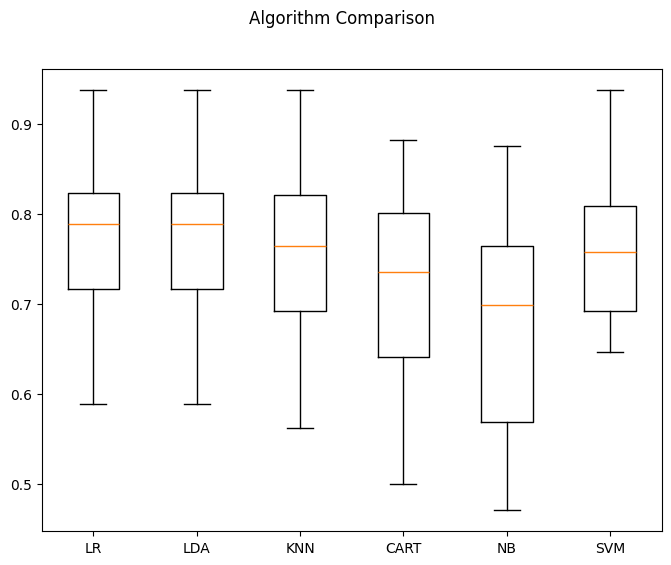

In [22]:
# compare algorithms

#plot boxplot
fig = plt.figure(figsize=(8, 6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

LR, LDA, and SVM performed better - both in terms of average and variance
KNN, CART, and NB showed the worst performance

In [23]:
# Standardize the dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()), ('LR', LogisticRegression(solver='lbfgs', max_iter=1000))])))
pipelines.append(('ScaledLDA', Pipeline([('Scaler', StandardScaler()), ('LDA', LinearDiscriminantAnalysis())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()), ('KNN', KNeighborsClassifier())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()), ('CART', DecisionTreeClassifier())])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()), ('NB', GaussianNB())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()), ('SVM', SVC(gamma='scale'))])))

# Evaluate algorithms on scaled dataset
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = 'Model %s:   mean: %f     std: %f' %(name, cv_results.mean(), cv_results.std())
    print(msg)

Model ScaledLR:   mean: 0.754412     std: 0.067926
Model ScaledLDA:   mean: 0.778676     std: 0.093570
Model ScaledKNN:   mean: 0.808456     std: 0.107996
Model ScaledCART:   mean: 0.776103     std: 0.069726
Model ScaledNB:   mean: 0.682721     std: 0.136040
Model ScaledSVM:   mean: 0.826103     std: 0.081814


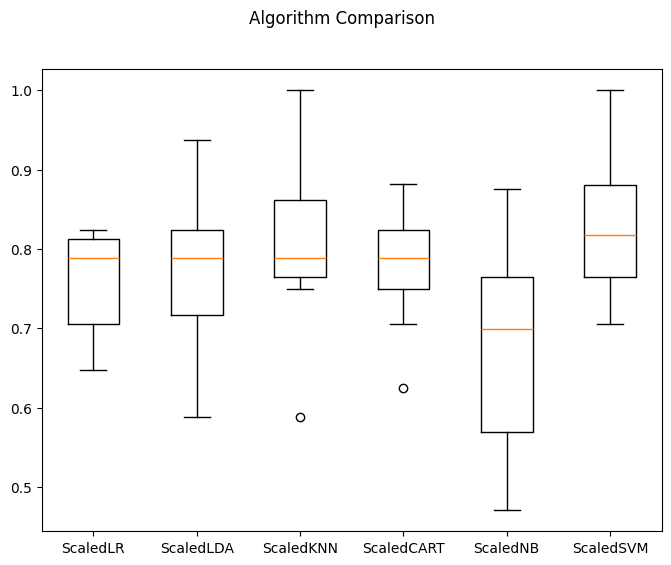

In [24]:
# compare algorithms

#plot boxplot
fig = plt.figure(figsize=(8, 6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### 5. Improve Accuracy

#### a) Algorithm Tuning

Best: 0.836029 using {'n_neighbors': np.int64(1)}
0.836029 (0.079487) with: {'n_neighbors': np.int64(1)}
0.794853 (0.115312) with: {'n_neighbors': np.int64(2)}
0.813603 (0.088021) with: {'n_neighbors': np.int64(3)}
0.796324 (0.110871) with: {'n_neighbors': np.int64(4)}
0.814338 (0.096870) with: {'n_neighbors': np.int64(5)}
0.747426 (0.123499) with: {'n_neighbors': np.int64(6)}
0.777574 (0.120387) with: {'n_neighbors': np.int64(7)}
0.735294 (0.106186) with: {'n_neighbors': np.int64(8)}
0.730147 (0.099376) with: {'n_neighbors': np.int64(9)}
0.723529 (0.093295) with: {'n_neighbors': np.int64(10)}
0.741544 (0.073970) with: {'n_neighbors': np.int64(11)}
0.729412 (0.093850) with: {'n_neighbors': np.int64(12)}
0.710662 (0.105829) with: {'n_neighbors': np.int64(13)}
0.711029 (0.097204) with: {'n_neighbors': np.int64(14)}
0.723162 (0.080983) with: {'n_neighbors': np.int64(15)}
0.704779 (0.075328) with: {'n_neighbors': np.int64(16)}
0.698897 (0.072669) with: {'n_neighbors': np.int64(17)}
0.69889

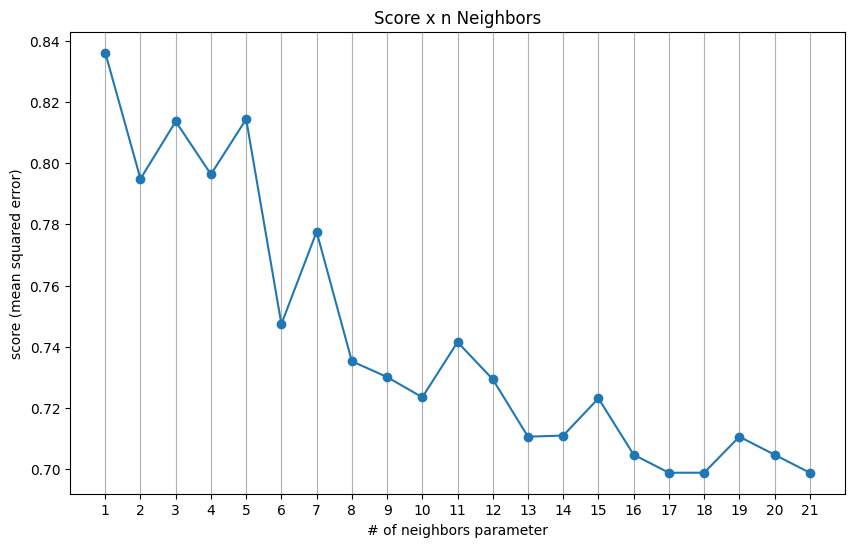

In [25]:
# Tuning KNN

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
k_values = np.arange(1, 22, dtype=int)
param_grid = dict(n_neighbors=k_values)
model = KNeighborsClassifier()
kfold = KFold(n_splits = num_folds, random_state = seed, shuffle = True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Extracting the 'n_neighbors' values from each dictionary
x_values = [d['n_neighbors'] for d in params]

# Plotting
plt.figure(figsize=(10, 6))
plt.title('Score x n Neighbors')
plt.plot(x_values, means, marker='o')
plt.grid(axis='x')
plt.xticks(np.arange(1, 22, 1))
plt.ylabel('score (mean squared error)')
plt.xlabel('# of neighbors parameter')
plt.show()

In [26]:
# Tuning SVM

# Tuning scaled SVM
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']

param_grid = dict(C = c_values, kernel = kernel_values)
model = SVC(gamma='scale')
kfold = KFold(n_splits = num_folds, random_state = 1235, shuffle = True)
grid = GridSearchCV(estimator = model, param_grid=param_grid, scoring=scoring, cv=kfold, return_train_score=False)
grid_result = grid.fit(rescaledX, Y_train)
print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param)) 

Best: 0.850000 using {'C': 1.7, 'kernel': 'rbf'}
0.777574 (0.093692) with: {'C': 0.1, 'kernel': 'linear'}
0.593015 (0.155711) with: {'C': 0.1, 'kernel': 'poly'}
0.513603 (0.117210) with: {'C': 0.1, 'kernel': 'rbf'}
0.705515 (0.081787) with: {'C': 0.1, 'kernel': 'sigmoid'}
0.765809 (0.121435) with: {'C': 0.3, 'kernel': 'linear'}
0.658088 (0.124436) with: {'C': 0.3, 'kernel': 'poly'}
0.706250 (0.102763) with: {'C': 0.3, 'kernel': 'rbf'}
0.765074 (0.084005) with: {'C': 0.3, 'kernel': 'sigmoid'}
0.766176 (0.119088) with: {'C': 0.5, 'kernel': 'linear'}
0.724632 (0.136302) with: {'C': 0.5, 'kernel': 'poly'}
0.765809 (0.076856) with: {'C': 0.5, 'kernel': 'rbf'}
0.765441 (0.092085) with: {'C': 0.5, 'kernel': 'sigmoid'}
0.759926 (0.117751) with: {'C': 0.7, 'kernel': 'linear'}
0.772794 (0.116455) with: {'C': 0.7, 'kernel': 'poly'}
0.801838 (0.096761) with: {'C': 0.7, 'kernel': 'rbf'}
0.759191 (0.099023) with: {'C': 0.7, 'kernel': 'sigmoid'}
0.771691 (0.117641) with: {'C': 0.9, 'kernel': 'linear'

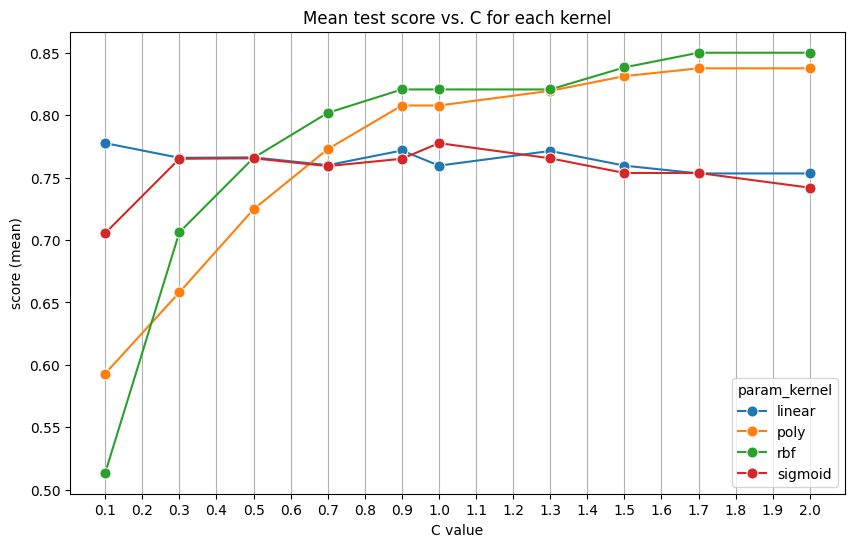

In [27]:
results_df = pd.DataFrame(grid_result.cv_results_)
selected_results_df = results_df[['mean_test_score', 'param_C', 'param_kernel']]

# Plotting
plt.figure(figsize=(10, 6))
plt.title('Mean test score vs. C for each kernel')
sns.lineplot(data=selected_results_df, x='param_C', y='mean_test_score', hue='param_kernel', marker='o', markersize=8)
plt.grid(axis='x')
plt.xticks(np.arange(0.1, 2.1, 0.1))
plt.ylabel('score (mean)')
plt.xlabel('C value')
plt.show()

#### b) Ensembles

In [34]:
# ensemble KNN
ensembles = []
ensembles.append(('AB', AdaBoostClassifier(algorithm='SAMME')))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier(n_estimators=10)))
ensembles.append(('ET', ExtraTreesClassifier(n_estimators=10)))
results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv = kfold, scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = "Model %s:   mean: %f   std: %f" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Model AB:   mean: 0.801838   std: 0.087303
Model GBM:   mean: 0.802206   std: 0.146237
Model RF:   mean: 0.764706   std: 0.117682
Model ET:   mean: 0.790074   std: 0.100932


In [36]:
# ensemble SVM
ensembles = []
ensembles.append(('AB', AdaBoostClassifier(algorithm='SAMME')))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier(n_estimators=10)))
ensembles.append(('ET', ExtraTreesClassifier(n_estimators=10)))
results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "Model %s:   mean: %f   std: %f" % (name, cv_results.mean(), cv_results.std())
    print(msg)



    # Tuning scaled SVM
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']

param_grid = dict(C = c_values, kernel = kernel_values)
model = SVC(gamma = 'auto')
kfold = KFold(n_splits = num_folds, random_state = 1235, shuffle = True)
grid = GridSearchCV(estimator = model, param_grid=param_grid, scoring=scoring, cv=kfold, return_train_score=False)
grid_result = grid.fit(rescaledX, Y_train)
print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param)) 

Model AB:   mean: 0.801838   std: 0.087303
Model GBM:   mean: 0.826103   std: 0.106998
Model RF:   mean: 0.752941   std: 0.072302
Model ET:   mean: 0.765074   std: 0.096956
Best: 0.850000 using {'C': 1.7, 'kernel': 'rbf'}
0.777574 (0.093692) with: {'C': 0.1, 'kernel': 'linear'}
0.587132 (0.159077) with: {'C': 0.1, 'kernel': 'poly'}
0.513603 (0.117210) with: {'C': 0.1, 'kernel': 'rbf'}
0.705515 (0.081787) with: {'C': 0.1, 'kernel': 'sigmoid'}
0.765809 (0.121435) with: {'C': 0.3, 'kernel': 'linear'}
0.651838 (0.121190) with: {'C': 0.3, 'kernel': 'poly'}
0.706250 (0.102763) with: {'C': 0.3, 'kernel': 'rbf'}
0.771324 (0.084970) with: {'C': 0.3, 'kernel': 'sigmoid'}
0.766176 (0.119088) with: {'C': 0.5, 'kernel': 'linear'}
0.724632 (0.127415) with: {'C': 0.5, 'kernel': 'poly'}
0.771691 (0.083050) with: {'C': 0.5, 'kernel': 'rbf'}
0.759191 (0.086381) with: {'C': 0.5, 'kernel': 'sigmoid'}
0.759926 (0.117751) with: {'C': 0.7, 'kernel': 'linear'}
0.784926 (0.126593) with: {'C': 0.7, 'kernel': 'p

In [42]:
# Define base estimator (Support Vector Classifier)
model = SVC(param_grid=2)

# Define parameter grid for GridSearchCV
param_grid = {
    'C': [1, 10],
    'kernel': ('linear', 'rbf')
}

# Create GridSearchCV instance
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

# Define AdaBoostClassifier with SVC base estimator
adaboost = AdaBoostClassifier(base_estimator=grid_search)

# Define k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
adaboost.fit(X_train_fold, y_train_fold)
score = adaboost.score(X_test_fold, y_test_fold)
scores.append(score)

# Evaluate model performance
mean_score = np.mean(scores)
print("Mean accuracy:", mean_score)


TypeError: SVC.__init__() got an unexpected keyword argument 'param_grid'

### 5.b PCA

In [44]:
array = df.values
X = array[:,0:-1].astype(float)
Y = array[:,-1]

In [45]:

pca = PCA(n_components=3)
pca_fit = pca.fit(X)
print("Explained Variance Ratio: %s" % pca_fit.explained_variance_ratio_)
print("Sum: %s" % pca_fit.explained_variance_ratio_.sum())
print(pca_fit.components_)

Explained Variance Ratio: [0.31971149 0.2038306  0.0855582 ]
Sum: 0.6091002869590061
[[ 6.66384143e-04  6.74901735e-04  5.20768151e-03  1.02589190e-02
   2.12619079e-02  1.77904998e-02  1.61857246e-02  1.05025566e-02
   1.06156960e-02  1.97162253e-02  4.62691640e-02  5.01088007e-02
   7.98525549e-02  1.29107900e-01  1.71859924e-01  2.09144504e-01
   2.55236483e-01  2.72279648e-01  2.78107743e-01  2.60189699e-01
   2.52753885e-01  2.52130911e-01  1.95224417e-01  1.34382716e-01
   9.21629567e-02  4.20276298e-02 -4.43394201e-03 -9.96705157e-02
  -1.52473152e-01 -1.77871127e-01 -1.80581631e-01 -1.80483244e-01
  -1.89780242e-01 -2.05544762e-01 -2.15991672e-01 -2.10438055e-01
  -1.65390090e-01 -1.45448160e-01 -1.21990818e-01 -1.06539629e-01
  -1.07340196e-01 -9.64259911e-02 -8.04276777e-02 -7.12279687e-02
  -7.80477962e-02 -6.81697151e-02 -3.53068134e-02 -2.46675392e-02
  -1.02100945e-02 -2.97480884e-03 -1.25865998e-03 -9.00507702e-04
  -5.86070215e-04  5.22137593e-04  1.86188752e-04  1.9365

In [47]:
from sklearn.feature_selection import RFE

model = LogisticRegression(solver='lbfgs', max_iter=1000)
rfe = RFE(model)
rfe_fit = rfe.fit(X, Y)

print("Num Features: %d" % rfe_fit.n_features_)
print("Selected Features: %s" % rfe_fit.support_)
print("Feature Ranking: %s" % rfe_fit.ranking_)

# maping scores to the attribute names
selected_col_indices = np.where(rfe_fit.support_)[0]
selected_col_name_list = [df.columns[i] for i in selected_col_indices]
print(selected_col_name_list)

Num Features: 30
Selected Features: [False False False  True  True False False False  True  True  True  True
  True False False  True  True False False  True  True  True  True False
 False False False  True False  True  True False False False  True  True
  True  True  True  True False  True  True  True  True  True  True  True
  True False False False False False False False False False False False]
Feature Ranking: [ 9  2  7  1  1 18 17 31  1  1  1  1  1 30  4  1  1 12 10  1  1  1  1  8
 11  5 22  1  6  1  1 13 25  3  1  1  1  1  1  1 15  1  1  1  1  1  1  1
  1 27 14 16 23 19 29 26 28 21 20 24]
['freqbin_04', 'freqbin_05', 'freqbin_09', 'freqbin_10', 'freqbin_11', 'freqbin_12', 'freqbin_13', 'freqbin_16', 'freqbin_17', 'freqbin_20', 'freqbin_21', 'freqbin_22', 'freqbin_23', 'freqbin_28', 'freqbin_30', 'freqbin_31', 'freqbin_35', 'freqbin_36', 'freqbin_37', 'freqbin_38', 'freqbin_39', 'freqbin_40', 'freqbin_42', 'freqbin_43', 'freqbin_44', 'freqbin_45', 'freqbin_46', 'freqbin_47', 'fre

In [49]:
# Define classifiers
classifiers = []

# Define pipelines for each classifier

# KNN
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rfe', RFE(estimator=KNeighborsClassifier(), n_features_to_select=10)),
    ('knn', KNeighborsClassifier(n_neighbors=5))])
classifiers.append(('KNN', knn_pipeline))

# SVM
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rfe', RFE(estimator=SVC(), n_features_to_select=10)),  # RFE for SVM
    ('svm', SVC(C=1.5, kernel='rbf'))
])
classifiers.append(('SVM', svm_pipeline))

# Define ensembles
ensembles = []
ensembles.append(('AB', AdaBoostClassifier(n_estimators=200, algorithm='SAMME')))
ensembles.append(('GBM', GradientBoostingClassifier(n_estimators=200)))
ensembles.append(('RF', RandomForestClassifier(n_estimators=200)))
ensembles.append(('ET', ExtraTreesClassifier(n_estimators=200)))

# Perform cross-validation and evaluate results for each classifier
for name, classifier in classifiers:
    results = []
    for ensemble_name, ensemble_model in ensembles:
        full_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('rfe', RFE(estimator=ensemble_model, n_features_to_select=10)),  # RFE for ensemble model
            ('classifier', ensemble_model)
        ])
        kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
        cv_results = cross_val_score(full_pipeline, X_train, Y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        msg = "Classifier: %s, Ensemble: %s, Mean: %f, Std: %f" % (name, ensemble_name, cv_results.mean(), cv_results.std())
        print(msg)

Classifier: KNN, Ensemble: AB, Mean: 0.740074, Std: 0.104039
Classifier: KNN, Ensemble: GBM, Mean: 0.693015, Std: 0.137495
Classifier: KNN, Ensemble: RF, Mean: 0.698897, Std: 0.074940
Classifier: KNN, Ensemble: ET, Mean: 0.770956, Std: 0.066463
Classifier: SVM, Ensemble: AB, Mean: 0.740074, Std: 0.104039
Classifier: SVM, Ensemble: GBM, Mean: 0.711397, Std: 0.133788
Classifier: SVM, Ensemble: RF, Mean: 0.699632, Std: 0.111149
Classifier: SVM, Ensemble: ET, Mean: 0.765074, Std: 0.082936


In [ ]:
# Tuning KNN

# Define the scaler and RFE
scaler = StandardScaler()
rfe = RFE(estimator=KNeighborsClassifier(n_neighbors=5), n_features_to_select=10)

# Construct the pipeline
pipeline = Pipeline([
    ('scaler', scaler),
    ('rfe', rfe),
    ('knn', KNeighborsClassifier())
])

# Define the parameters for grid search
param_grid = {
    'knn__n_neighbors': np.arange(1, 22)
}

# Perform GridSearchCV
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scoring, cv=kfold, iid=False)
grid_result = grid_search.fit(X_train, Y_train)

# Print best results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

# Extracting the 'knn__n_neighbors' values from each dictionary
x_values = [d['knn__n_neighbors'] for d in params]

# Plotting
plt.figure(figsize=(10, 6))
plt.title('Score x n Neighbors')
plt.plot(x_values, means, marker='o')
plt.grid(axis='x')
plt.xticks(np.arange(1, 22, 1))
plt.ylabel('Score')
plt.xlabel('# of Neighbors')
plt.show()

In [ ]:
# Tuning SVM

# Define the scaler and RFE
scaler = StandardScaler()
rfe = RFE(estimator=SVC(gamma='scale'), n_features_to_select=10)

# Construct the pipeline
pipeline = Pipeline([
    ('scaler', scaler),
    ('rfe', rfe),
    ('svm', SVC())
])

# Define the parameter grid
c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = {'svm__C': c_values, 'svm__kernel': kernel_values}

# Perform GridSearchCV
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scoring, cv=kfold, return_train_score=False, iid=False)
grid_result = grid_search.fit(X_train, Y_train)
print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))

# Extract and prepare results for plotting
results_df = pd.DataFrame(grid_result.cv_results_)
selected_results_df = results_df[['mean_test_score', 'param_svm__C', 'param_svm__kernel']]

# Plotting
plt.figure(figsize=(10, 6))
plt.title('Mean test score vs. C for each kernel')
sns.lineplot(data=selected_results_df, x='param_svm__C', y='mean_test_score', hue='param_svm__kernel', marker='o', markersize=8)
plt.grid(axis='x')
plt.xticks(np.arange(0.1, 2.1, 0.1))
plt.ylabel('Score (mean)')
plt.xlabel('C value')
plt.show()

### 6. Finalize Model

#### a) Predictions on validation dataset

#### b) Create standalone model on entire training dataset

#### c) Save model for later use